# VGG Ablation Study

## 0. Ablation Study

* ["In the context of deep learning, what is an ablation study?"](https://www.quora.com/In-the-context-of-deep-learning-what-is-an-ablation-study)

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시한다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 
* 해당 방법을 "제거"한 모델로 수행한 실험의 결과
* 해당 방법을 추가한 모델로 수행한 실험의 결과

를 비교한다. 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험이다.

## 1. Ablation Study CIFAR-10 데이터셋 준비하기

CIFAR-10에 대해 VGG-16과 VGG-19를 구현해서 이 둘을 비교하여 layer의 유효성을 확인할 것이다.

### 1) CIFAR-10
---
<img src="./image/cifar_10.png" />

* [CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10)

CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)이다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /home/aiffel-dj10/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 2) Input Normalization
---
* [딥러닝 용어 정리, Normalization(정규화) 설명](https://light-tree.tistory.com/132)

Data Normalization 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것이다. 이미지 데이터의 경우 픽셀 정보를 0 ~ 255 사이의 값으로 가지는데, 이를 255로 나누어주면 0 ~ 1.0 사이의 값을 가지게 될 것이다.

위의 예를 수식으로 간단하게 쓴다면,

(정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값)

이다. 

<img src="./image/normalization.jpeg" width="70%" />

<img src="./image/normalization2.png" width="70%" />

왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다.

각 채널별 최댓값인 255로 __정규화(normalize)__를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어준다.

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

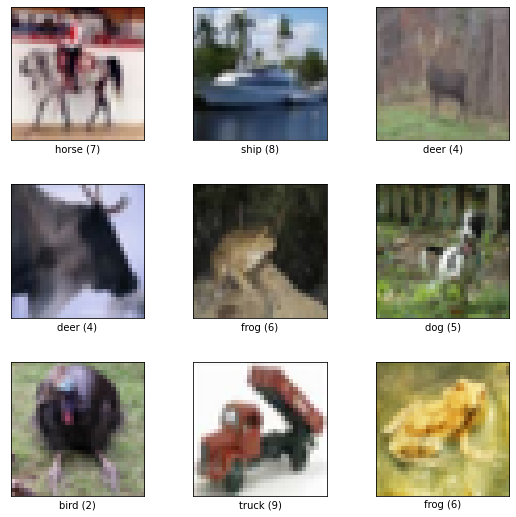

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

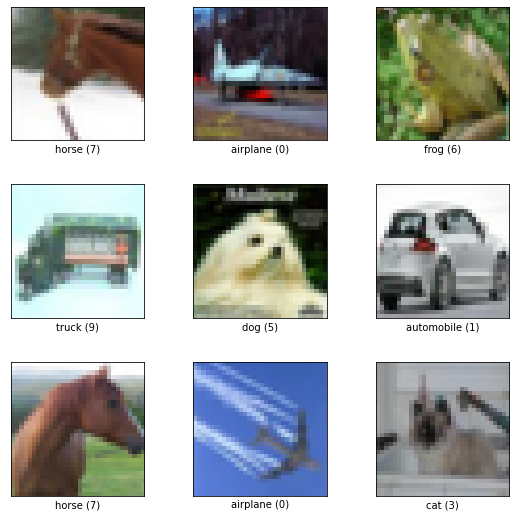

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 2. Ablation Study 블록 구성하기

딥러닝 모델에서 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 __블록(block)__ 이라고 부른다. __레이어(layer)__ 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위이다. 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 한다.

### VGG 기본 블록 만들기
---
<img src="./image/vgg.png" />

__모델 블록__

* VGG의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어진다. 
* CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있다. 
* 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다. 
* 블록에 따라서 CNN 레이어의 갯수 또한 달라진다. 
* 블록의 마지막에는 항상 Max Pooling 레이어가 붙는다. 
* 따라서 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 한다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 `input_layer` 에 추가할 수 있다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 `(32,32,3)` 이 된다. 이 입력 레이어를 인자로 받아 `build_vgg_block()` 는 블록의 레이어를 build하고 출력값을 얻을 수 있다. 이제 케라스의 `Model` 클래스에서 `input`과 `output`을 정의해주면 간단히 블록의 모델을 확인해볼 수 있다.

* 참고: [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## 3. Ablation Study VGG Complete Model

### 1) VGG-16
---
블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라진다. 

* 각 블록 별 CNN의 수와 채널을 리스트로 만들었다.

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### 2) VGG-19
---

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## 4. Ablation Study 실습 (4) VGG-16 vs VGG-19

__VGG-16__과 __VGG-19__를 비교.

In [18]:
BATCH_SIZE = 256
EPOCH = 20

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [20]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 49s 161ms/step - loss: 2.2486 - accuracy: 0.1557 - val_loss: 2.0855 - val_accuracy: 0.2531
Epoch 2/20
195/195 [==============================] - 23s 116ms/step - loss: 2.0472 - accuracy: 0.2580 - val_loss: 1.9168 - val_accuracy: 0.3193
Epoch 3/20
195/195 [==============================] - 17s 87ms/step - loss: 1.9057 - accuracy: 0.3129 - val_loss: 1.8399 - val_accuracy: 0.3435
Epoch 4/20
195/195 [==============================] - 17s 88ms/step - loss: 1.7885 - accuracy: 0.3633 - val_loss: 1.7109 - val_accuracy: 0.3880
Epoch 5/20
195/195 [==============================] - 17s 89ms/step - loss: 1.7039 - accuracy: 0.3908 - val_loss: 1.6686 - val_accuracy: 0.4027
Epoch 6/20
195/195 [==============================] - 17s 87ms/step - loss: 1.6203 - accuracy: 0.4169 - val_loss: 1.5466 - val_accuracy: 0.4440
Epoch 7/20
195/195 [==============================] - 17s 87ms/step - loss: 1.5719 - accuracy: 0.4364 - val_loss: 1.5710 - val_accurac

In [21]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 22s 101ms/step - loss: 2.2806 - accuracy: 0.1329 - val_loss: 2.1433 - val_accuracy: 0.2114
Epoch 2/20
195/195 [==============================] - 19s 97ms/step - loss: 2.0963 - accuracy: 0.2283 - val_loss: 1.9838 - val_accuracy: 0.2964
Epoch 3/20
195/195 [==============================] - 19s 97ms/step - loss: 1.9524 - accuracy: 0.2890 - val_loss: 1.8528 - val_accuracy: 0.3207
Epoch 4/20
195/195 [==============================] - 19s 96ms/step - loss: 1.8152 - accuracy: 0.3444 - val_loss: 1.6813 - val_accuracy: 0.3864
Epoch 5/20
195/195 [==============================] - 19s 96ms/step - loss: 1.7167 - accuracy: 0.3801 - val_loss: 1.6365 - val_accuracy: 0.4038
Epoch 6/20
195/195 [==============================] - 19s 96ms/step - loss: 1.6465 - accuracy: 0.4035 - val_loss: 1.5963 - val_accuracy: 0.4280
Epoch 7/20
195/195 [==============================] - 19s 97ms/step - loss: 1.5897 - accuracy: 0.4200 - val_loss: 1.5859 - val_accuracy

훈련 손실(training loss)

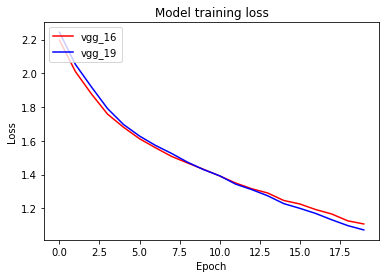

In [22]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

검증 정확도(validation accuracy)

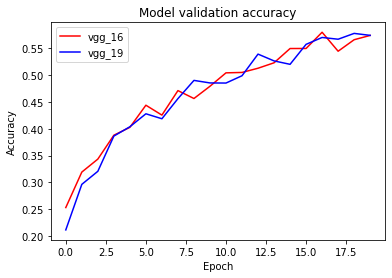

In [23]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

VGG-19가 조금 더 높은 정확도를 보인다.